# Write a categorizer

## Wooheum Xin

13 August 2022

Introduction to Computational Literary Analysis

Department of Digital Humanities, University of California, Berkeley

Instructor: Jonathan Reeve


In [1]:
import spacy
import nltk
import pandas as pd
import sklearn
import numpy as np
import string
import json
import requests
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
nlp = spacy.load('en_core_web_lg')
import matplotlib
plt.rc('font', family='SimSun')
print(plt.rcParams['font.family'])

c:\Users\xin98\.conda\envs\notebook\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['SimSun']


### Go to corpus-db to see which subjects are available

In [2]:
baseURL = "http://corpus-db.org" 
allSubjects = requests.get(baseURL + "/api/subjects").text
subjects = json.loads(allSubjects)
subjects[:15]

[['Fiction', 1920],
 ['Short stories', 1581],
 ['Science fiction', 1283],
 ['Adventure stories', 766],
 ['Historical fiction', 634],
 ['Poetry', 633],
 ['Love stories', 619],
 [', ', 557],
 ['English wit and humor -- Periodicals', 555],
 ['Conduct of life -- Juvenile fiction', 554],
 ['Detective and mystery stories', 537],
 ['Western stories', 432],
 ['Man-woman relationships -- Fiction', 389],
 ['England -- Fiction', 309],
 ['Friendship -- Juvenile fiction', 307]]

### Determined by four subjects
>'Detective and mystery stories','Adventure stories','Love stories','Science fiction'

In [3]:
sub_list=['Detective and mystery stories','Adventure stories','Love stories','Science fiction']
AllMeta={} 
def getMeta(sub_list):
    for sub in sub_list:
        AllMeta[sub]=json.loads(requests.get(baseURL + "/api/subject/"+sub).text)
getMeta(sub_list)

### Appending a fixed number of novels in the Fulltext[].

In [13]:
def Meta2Fulltext(Meta,num):
    Fulltext,usefull_link=[],[]
    counter=0
    for index in range(len(Meta)):
        start_num=Meta[index]['formats'].find('text/plain; charset=utf-8')+29
        if(start_num==28):
            start_num=Meta[index]['formats'].find("text/plain':")+14
            if(start_num==13):
                continue
        new_str=Meta[index]['formats'][start_num:]
        weblink=new_str[:new_str.find("'")]
        if(weblink[-3:]=='zip'):
            continue
        usefull_link.append(weblink)
        counter=counter+1
        if(counter==num):
            break
    for index in tqdm(range(len(usefull_link))):
        tmptext=requests.get(usefull_link[index])
        Fulltext.append(tmptext.text)
    return Fulltext

In [15]:
AllText={}
for key, value in AllMeta.items():
    print("Loading :"+key)
    AllText[key]=Meta2Fulltext(value,100)

Loading :Detective and mystery stories


  0%|          | 0/100 [00:00<?, ?it/s]

Loading :Adventure stories


  0%|          | 0/100 [00:00<?, ?it/s]

Loading :Love stories


  0%|          | 0/100 [00:00<?, ?it/s]

Loading :Science fiction


  0%|          | 0/100 [00:00<?, ?it/s]

### Clearing any unwanted parts of the text.

In [16]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]
def Get_Text(ALLTexts):
    df=pd.DataFrame(columns=['subject','novel'])
    for cate,novel in ALLTexts.items():
        for text in novel:
            end_num=text.find("*** END OF ")
            start_num=text.find("*** START OF ")+3
            tmp=text[start_num:].find("***")+3
            finalText=text[start_num+tmp:end_num]
            finalText = finalText.strip().replace("\n", " ").replace("\r", " ")
            finalText = finalText.lower()
            df.loc[len(df.index)]=[cate,finalText ]
    return df

### Separating 33% of the dataset for testing purposes

In [17]:
AllCleanText=Get_Text(AllText)
train, test = train_test_split(AllCleanText, test_size=0.33, random_state=42)
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Training Data Shape: (268, 2)
Testing Data Shape: (132, 2)


### Use spaCy for text preprocessing, and then try to find the most used word in each subject

In [25]:
nlp.max_length = 20000000
punctuations = string.punctuation
def cleanup_text(docs, logging=True):
    texts = []
    counter = 1
    pbar=tqdm(docs)
    for doc in pbar:
        if counter % 1000 != 0 and logging:
            pbar.set_description("Processing %s" %counter)
            # print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in STOPLIST and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)
clean_text={}
for sub in sub_list:
    clean_text[sub]=[text for text in train[train['subject'] == sub]['novel']]
    clean_text[sub]=' '.join(cleanup_text(clean_text[sub])).split()

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

c:\Users\xin98\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xin98\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xin98\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 156 (\x9c) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


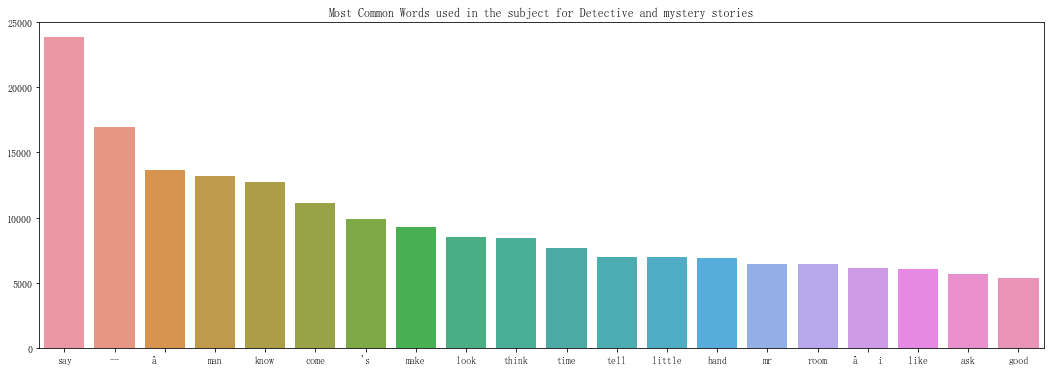

c:\Users\xin98\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xin98\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


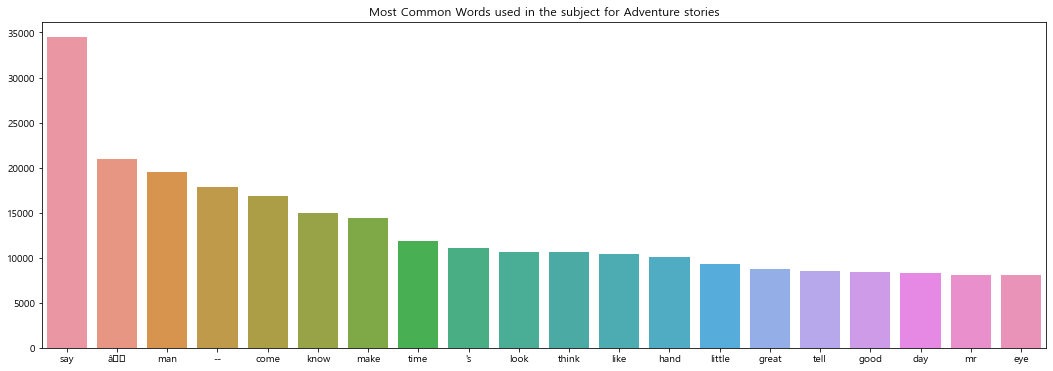

c:\Users\xin98\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xin98\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


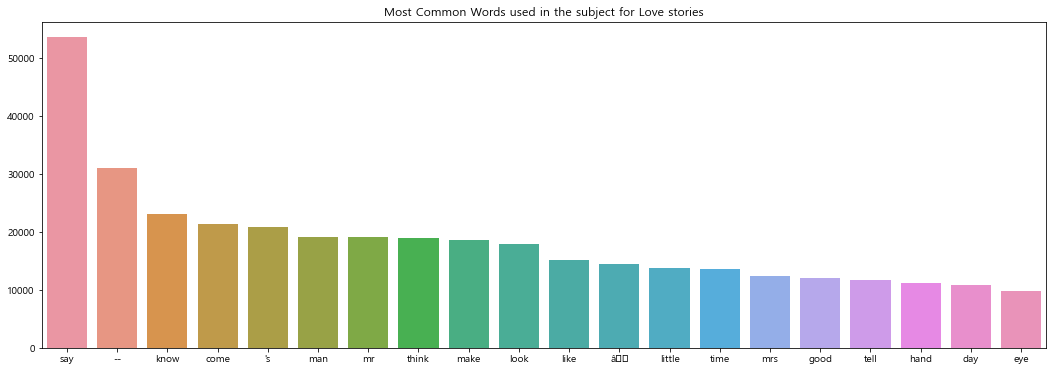

c:\Users\xin98\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xin98\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


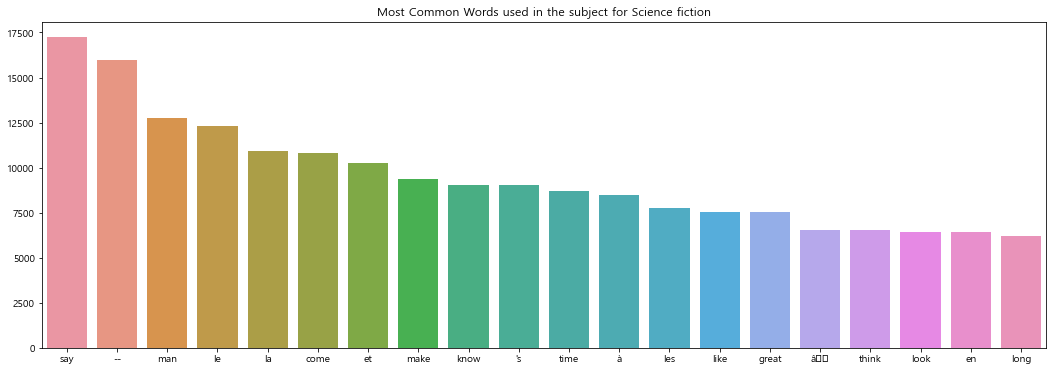

In [26]:
for sub in sub_list:
    counts=Counter(clean_text[sub])
    common_words=[word[0] for word in counts.most_common(20)]
    common_counts= [word[1] for word in counts.most_common(20)]
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_words, y=common_counts)
    plt.title('Most Common Words used in the subject for '+sub)
    plt.rc('font', family='Malgun Gothic')
    plt.show()

## Machine Learning with SpaCy
### First we load the spacy model Create language processing objects.Then clean up the text with spaCy.Finally, we define a function to show the most significant features, with the highest correlation coefficients

In [30]:
nlp.max_length = 30000000
def cleanText_spacy(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text
class CleanTextTransformer(TransformerMixin):   
    def transform(self, X, **transform_params):
        return [cleanText_spacy(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}
def tokenizeText(sample):
    tokens = nlp(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = [tok for tok in lemmas if tok not in [list(STOPLIST)+SYMBOLS]]
    return tokens
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names_out()
    subject_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = subject_with_fns[:N]
    topClass2 = subject_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,2))
clf = LinearSVC(max_iter=1500000,verbose=True)
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

In [31]:
# data
train1 = train['novel'].tolist()
labelsTrain1 = train['subject'].tolist()
test1 = test['novel'].tolist()
labelsTest1 = test['subject'].tolist()

In [32]:
# train
pipe.fit(train1, labelsTrain1)

[LibLinear]

c:\Users\xin98\.conda\envs\notebook\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('cleanText',
                 <__main__.CleanTextTransformer object at 0x000002113D5A4E20>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function tokenizeText at 0x0000021140CE5B80>)),
                ('clf', LinearSVC(max_iter=1500000, verbose=True))])

In [33]:
# test
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")
printNMostInformative(vectorizer, clf, 10)

accuracy: 0.6590909090909091
Top 10 features used to predict: 
Class 1 best: 
(-0.002433847469856842, 'detective')
(-0.0024188049136491855, ':')
(-0.0024100473245777724, 'in')
(-0.0019844925803132844, 'holmes')
(-0.0016926928753638727, '. ')
(-0.0016855530427168576, 'it')
(-0.0016536205219722887, 'read')
(-0.0015528777223386594, 'you')
(-0.0015312585961045255, ': ')
(-0.0014776630946859684, 'elephant')
Class 2 best: 
(0.003736269998201579, ' the')
(0.002085738187814468, 'on')
(0.0018620159926107229, 'cleggett')
(0.0017630686206821303, 'boy')
(0.0016264766683094017, 'harry')
(0.0015937568512690318, 'lion')
(0.0015660868016241503, '. .')
(0.0015097318678284123, 'rob')
(0.0014806946786881587, 'very')
(0.0013985720118322542, 'he')


In [34]:
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names_out()
for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

### Calculation accuracy, recall, F1 score:

In [35]:
from sklearn import metrics
print(metrics.classification_report(labelsTest1, preds, target_names=sub_list))

                               precision    recall  f1-score   support

Detective and mystery stories       0.54      0.67      0.60        30
            Adventure stories       0.77      0.69      0.73        39
                 Love stories       0.64      0.58      0.61        31
              Science fiction       0.69      0.69      0.69        32

                     accuracy                           0.66       132
                    macro avg       0.66      0.66      0.66       132
                 weighted avg       0.67      0.66      0.66       132

